In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



In [19]:
df_long = pd.read_csv('metricR2.csv')

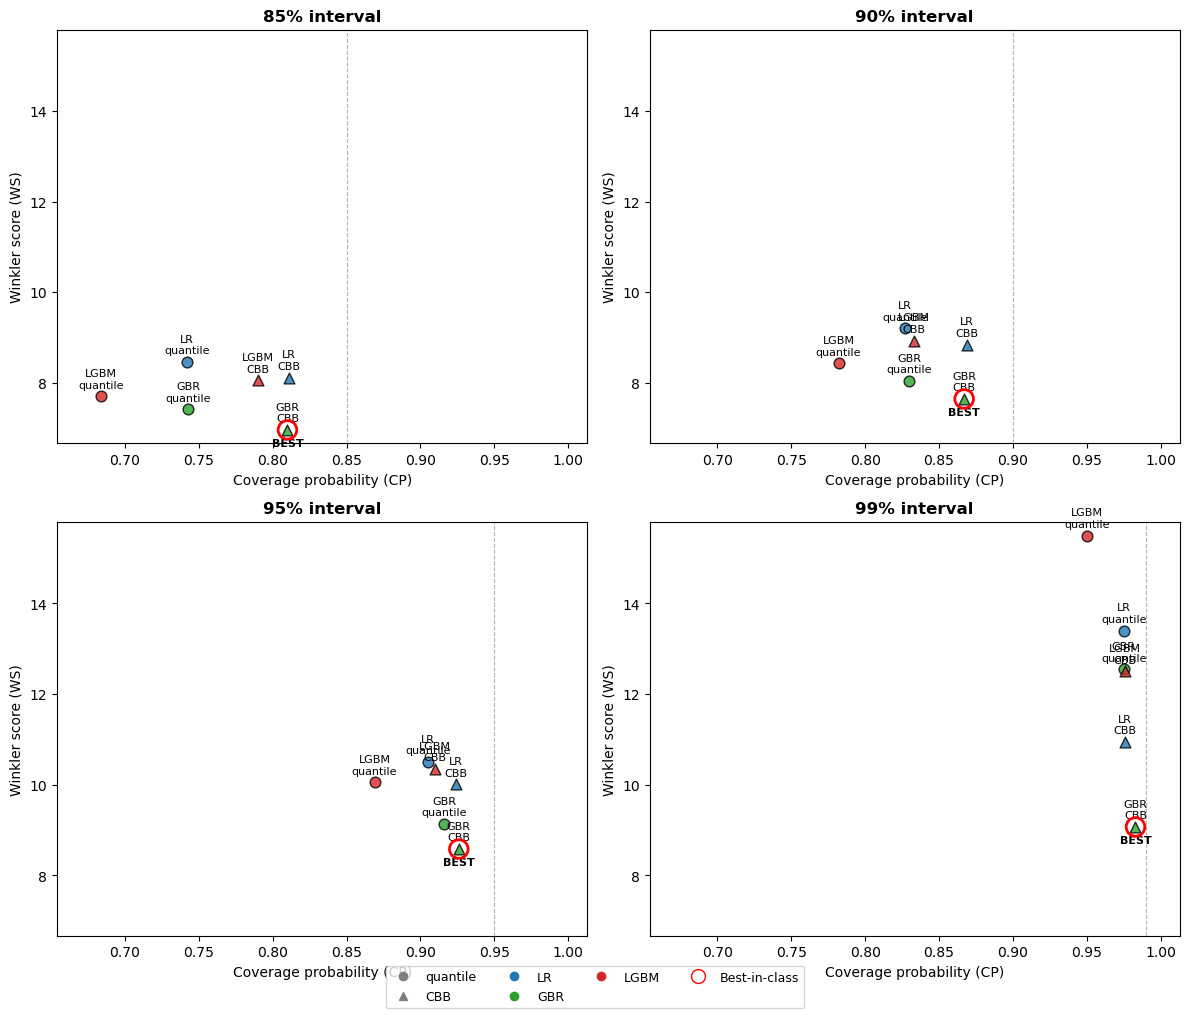

In [20]:
df_long   = df_long[~df_long.ML.str.lower().eq("prophet")]   # <-- remove Prophet
conf_cols = ["85", "90", "95", "99"]
df_long[conf_cols] = df_long[conf_cols].apply(pd.to_numeric, errors="coerce")

df_ws = df_long[df_long.Metric.eq("WS")].set_index("ML")[conf_cols]
df_cp = df_long[df_long.Metric.eq("CP")].set_index("ML")[conf_cols]

# ------------------------------------------------------------------
# 2. Styling helpers (no Prophet entry now)
# ------------------------------------------------------------------
cat_markers = {"quantile": "o", "CBB": "^", "Other": "s"}
model_colors = {"LR": "#1f77b4", "GBR": "#2ca02c", "LGBM": "#d62728", "Other": "#7f7f7f"}

def parse_model(label: str):
    """
    Return (algorithm, category) for labels like 'LR_quantile', 'GBR_CBB'.
    Prophet is already removed, so we don't special-case it.
    """
    label = str(label).strip()
    if "_" in label:
        algo, cat = label.split("_", 1)
        return algo, cat
    parts = label.split(maxsplit=1)
    return parts[0], parts[1] if len(parts) == 2 else ("Other", "Other")

# ------------------------------------------------------------------
# 3. Flag best model per confidence level
# ------------------------------------------------------------------
best = {}
for col in conf_cols:
    cp_norm = (df_cp[col] - df_cp[col].min()) / (df_cp[col].max() - df_cp[col].min())
    ws_norm = 1 - (df_ws[col] - df_ws[col].min()) / (df_ws[col].max() - df_ws[col].min())
    best[col] = (0.6 * cp_norm + 0.4 * ws_norm).idxmax()

# ------------------------------------------------------------------
# 4. Make four CP-vs-WS panels
# ------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes      = axes.ravel()
conf_vals = [0.85, 0.90, 0.95, 0.99]

cp_min, cp_max = df_cp.min().min() - .03, df_cp.max().max() + .03
ws_min, ws_max = df_ws.min().min() - .30, df_ws.max().max() + .30

handles_cat, handles_alg = {}, {}

for k, col in enumerate(conf_cols):
    ax = axes[k]
    ax.set_title(f"{col}% interval", fontsize=12, weight="bold")
    ax.set_xlabel("Coverage probability (CP)", fontsize=10)
    ax.set_ylabel("Winkler score (WS)",       fontsize=10)
    ax.set_xlim(cp_min, cp_max)
    ax.set_ylim(ws_min, ws_max)
    ax.axvline(conf_vals[k], color="grey", ls="--", lw=0.8, alpha=0.6)

    for model in df_cp.index:
        algo, cat = parse_model(model)
        marker    = cat_markers.get(cat,   cat_markers["Other"])
        colour    = model_colors.get(algo, model_colors["Other"])
        x, y      = df_cp.at[model, col], df_ws.at[model, col]

        ax.scatter(x, y, marker=marker, s=60, c=colour,
                   edgecolor="k", alpha=0.8)
        ax.annotate(model.replace("_", "\n"), (x, y),
                    xytext=(0, 6), textcoords="offset points",
                    ha="center", fontsize=8)

        if model == best[col]:                       # highlight best
            ax.scatter(x, y, s=180, facecolors="none", edgecolors="red",
                       lw=2, zorder=5)
            ax.annotate("BEST", (x, y), xytext=(0, -12),
                        textcoords="offset points", ha="center",
                        fontsize=8, weight="bold")

        # legend proxies (avoid duplicates)
        if cat not in handles_cat:
            handles_cat[cat] = plt.Line2D([0], [0], marker=marker, color="grey",
                                          markersize=6, lw=0, label=cat)
        if algo not in handles_alg:
            handles_alg[algo] = plt.Line2D([0], [0], marker="o", color=colour,
                                           markersize=6, lw=0, label=algo)

# ------------------------------------------------------------
# 5. Legend
# ------------------------------------------------------------
legend_handles = list(handles_cat.values()) + list(handles_alg.values())
legend_labels  = [h.get_label() for h in legend_handles]
best_proxy     = plt.Line2D([0], [0], marker="o", mfc="none", mec="red",
                            markersize=10, lw=0)
legend_handles.append(best_proxy)
legend_labels.append("Best-in-class")

fig.legend(handles=legend_handles, labels=legend_labels,
           ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.02),
           fontsize=9)

plt.tight_layout()
# plt.savefig("cp_vs_ws_grid_no_prophet.png", dpi=600, bbox_inches="tight")
plt.show()

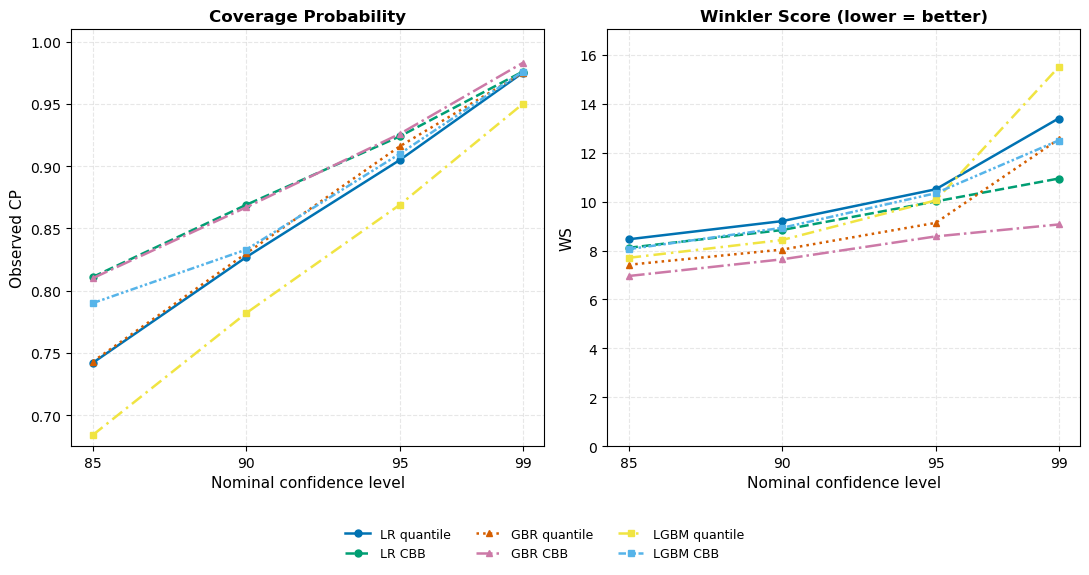

In [47]:

df = pd.read_csv("metricR2.csv")
df = df[~df.ML.str.lower().eq("prophet")]            # drop Prophet
conf = ["85", "90", "95", "99"]
df[conf] = df[conf].apply(pd.to_numeric, errors="coerce")

cp = df[df.Metric.eq("CP")].set_index("ML")[conf]
ws = df[df.Metric.eq("WS")].set_index("ML")[conf]

# ------------------------------------------------------------
# 2. Pre-define colour-blind palette + dash styles
# ------------------------------------------------------------
okabe_ito = ["#0072B2", "#009E73", "#D55E00",
             "#CC79A7", "#F0E442", "#56B4E9"]        # 6 hues

models = [
    "LR_quantile", "LR_CBB",
    "GBR_quantile", "GBR_CBB",
    "LGBM_quantile", "LGBM_CBB"
]

style = {mdl: dict(color=okabe_ito[i],
                   ls  = ls,           # line style
                   marker=mk)          # marker
         for i, (mdl, ls, mk) in enumerate(zip(
             models,
             ["-", "--", ":", "-.", (0,(5,2,1,2)), (0,(3,1,1,1,1,1))],
             ["o", "o", "^", "^", "s", "s"]
         ))}

# ------------------------------------------------------------
# 3. Figure with 2 panels
# ------------------------------------------------------------
x = [0.85, 0.90, 0.95, 0.99]             # numeric x-axis
fig, (ax_cp, ax_ws) = plt.subplots(1, 2, figsize=(11, 5.5), dpi=100)

# --- CP panel -------------------------------------------------
for mdl in models:
    ax_cp.plot(x, cp.loc[mdl],
               label=mdl.replace("_", " "),
               linewidth=1.8,
               markersize=5,
               **style[mdl])

ax_cp.set_title("Coverage Probability", fontsize=12, weight="bold")
ax_cp.set_xlabel("Nominal confidence level", fontsize=11)
ax_cp.set_ylabel("Observed CP", fontsize=11)
ax_cp.set_xticks(x, conf)
ax_cp.set_ylim(0.675, 1.01)
ax_cp.grid(alpha=0.3, linestyle="--")

# --- WS panel -------------------------------------------------
for mdl in models:
    ax_ws.plot(x, ws.loc[mdl],
               linewidth=1.8,
               markersize=5,
               **style[mdl])

ax_ws.set_title("Winkler Score (lower = better)", fontsize=12, weight="bold")
ax_ws.set_xlabel("Nominal confidence level", fontsize=11)
ax_ws.set_ylabel("WS", fontsize=11)
ax_ws.set_xticks(x, conf)
ax_ws.set_ylim(0, ws.values.max()*1.1)
ax_ws.grid(alpha=0.3, linestyle="--")

# --- Combined legend (outside) --------------------------------
handles, labels = ax_cp.get_legend_handles_labels()
fig.legend(handles, labels,
           bbox_to_anchor=(0.5, 0.05), loc="upper center",
           ncol=3, fontsize=9, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 1])   # leave space for legend
# plt.savefig("cp_ws_two_panel_600dpi.png", dpi=600, bbox_inches="tight")  # ← final save
plt.show()


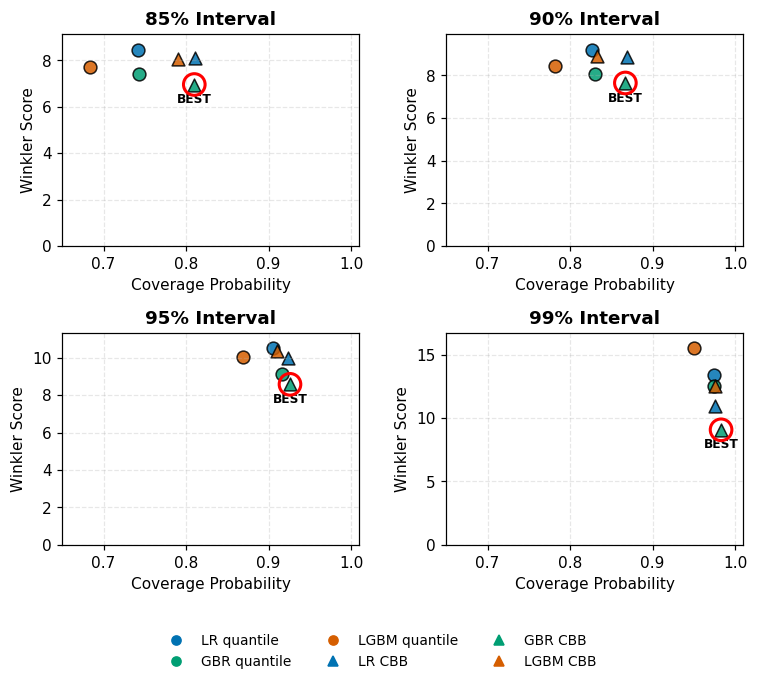

In [46]:
df  = pd.read_csv("metricR2.csv")
df  = df[~df.ML.str.lower().eq("prophet")]        # drop Prophet
alphas = ["85","90","95","99"]
df[alphas] = df[alphas].apply(pd.to_numeric, errors="coerce")

# Split wide → CP & WS tables
cp_tbl = df[df.Metric.eq("CP")].set_index("ML")[alphas]
ws_tbl = df[df.Metric.eq("WS")].set_index("ML")[alphas]

# Okabe–Ito palette (colour-blind safe) + markers by framework
colors  = dict(zip(["LR","GBR","LGBM"], ["#0072B2","#009E73","#D55E00"]))
markers = {"quantile":"o", "CBB":"^"}

def parse(name):            # 'LR_quantile' -> ('LR','quantile')
    algo, cat = name.split("_")
    return algo, cat

# ------------------------------------------------------------
# 2. 2×2 grid of trade-off plots
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(7, 6), dpi=110)
axes = axes.ravel()
nominal = [0.85, 0.90, 0.95, 0.99]                 # for panel titles

for idx, alpha in enumerate(alphas):
    ax = axes[idx]
    ax.set_title(f"{alpha}% Interval", fontsize=12, weight="bold")
    ax.set_xlabel("Coverage Probability", fontsize=10)
    ax.set_ylabel("Winkler Score", fontsize=10)
    ax.grid(True, ls="--", alpha=.3)
    ax.set_xlim(0.65, 1.01)
    ax.set_ylim(0, ws_tbl[alpha].max()*1.08)

    # Plot every model
    for model in cp_tbl.index:
        algo, cat = parse(model)
        x, y      = cp_tbl.at[model, alpha], ws_tbl.at[model, alpha]
        ax.scatter(x, y, s=70, color=colors[algo], marker=markers[cat],
                   edgecolor='k', alpha=.85, label=model)

    # Identify & highlight best (max CP, then min WS)
    cp_series, ws_series = cp_tbl[alpha], ws_tbl[alpha]
    best_model = cp_series.idxmax() if (cp_series.max()==1) else (
                 (0.5*(cp_series - cp_series.min())/(cp_series.max()-cp_series.min())
                +0.5*(1 - (ws_series - ws_series.min())/(ws_series.max()-ws_series.min()))).idxmax())

    bx, by = cp_tbl.at[best_model, alpha], ws_tbl.at[best_model, alpha]
    ax.scatter(bx, by, s=200, facecolors='none', edgecolors='red',
               linewidths=2.0, zorder=5)
    ax.annotate("BEST", (bx, by), xytext=(0,-12), textcoords="offset points",
                ha="center", fontsize=8, weight="bold")

# ------------------------------------------------------------
# 3. Unified legend (outside)
# ------------------------------------------------------------
handles, labels = [], []
for model in cp_tbl.index:
    algo, cat = parse(model)
    h = plt.Line2D([0], [0], marker=markers[cat], color=colors[algo],
                   markersize=6, lw=0)
    handles.append(h); labels.append(model.replace("_", " "))

fig.legend(handles, labels, bbox_to_anchor=(0.5, 0.05),
           loc="upper center", ncol=3, fontsize=9, frameon=False)

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig("cp_ws_tradeoff_4panel.png", dpi=700, bbox_inches="tight")  # submission-ready
plt.show()